In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from linopy import Model

In [2]:
# Technologies data:
tech_param = pd.read_csv('Data/technologies.csv',index_col=0)

In [3]:
# Storages data
sto_param = pd.read_csv("Data/storage_technologies.csv", index_col=0).to_xarray()

In [4]:
# Demand:
demand = pd.read_csv('Data/demand_hourly_Abu_Dhabi.csv',index_col=0, delimiter = ';').to_xarray()

In [5]:
# Global parameters:
general_parameters = pd.read_csv('Data/global_parameters.csv',index_col=0)

In [6]:
AF = pd.read_csv('Data/AF.csv',index_col=0, delimiter = ';') # AF is given in the file only for the renewables, we need to add columns for the other technologies.
for tech in tech_param.index:
    if tech not in AF.columns:
        AF.loc[:,tech] = tech_param.loc[tech, "Availability"] 
tech_param = tech_param.to_xarray()

In [7]:
### Sets
Time = demand.get_index("Time")
Tech = tech_param.get_index("Technologies")
Sto = sto_param.get_index("Storages")


# Technologies related
TECH_MAX_CAP = tech_param['Maximum capacity']
print(TECH_MAX_CAP)
MARGINAL_FUEL_COST = tech_param['Fuel costs']/tech_param['Rated efficiency']
CO2_INTENSITY = tech_param['Fuel CO2 content']/tech_param['Rated efficiency']
MARGINAL_CO2_EMISSION = tech_param['Fuel CO2 content']
TECH_PHI = tech_param["Discount rate"]/(1-(1+tech_param["Discount rate"])**(-tech_param["Lifetime"]))
TECH_IC = TECH_PHI*tech_param['Investment cost']
DELTA_MAX_UP = tech_param['Ramp-up rate']
DELTA_MAX_DOWN = tech_param['Ramp-down rate']
AF = AF[Tech]
AF  = xr.DataArray(AF,coords=[Time,Tech])
LEGACY = tech_param["Legacy capacity"]

# Storage related
STO_MAX_CAP = sto_param["Maximum capacity"]
STO_PHI = sto_param["Discount rate"]/(1-(1+sto_param["Discount rate"])**(-sto_param["Lifetime"]))
STO_IC = STO_PHI*sto_param["Investment cost"]
EFF_D = sto_param["Discharge efficiency"]
EFF_C = sto_param["Charge efficiency"]
SOC_MAX = sto_param["Maximum state of charge"]
SOC_MIN = sto_param["Minimum state of charge"]
STO_dT = sto_param["Storage duration"]


# Configuration and scenario parameters
DEMAND = demand["Campus_elec"]
TS = float(general_parameters.Value.loc['Time step'])
VOLL = float(general_parameters.Value.loc['VOLL'])
CO2_PRICE = float(general_parameters.Value.loc['CO2_price'])
CO2_BOUND = float(general_parameters.Value.loc['CO2_bound'])

<xarray.DataArray 'Maximum capacity' (Technologies: 4)> Size: 32B
array([300000, 300000,  30000,  30000])
Coordinates:
  * Technologies  (Technologies) object 32B 'Grid' 'GT' 'Wind' 'PV'


In [8]:
### Create the model instance

m = Model()

### Create the variables

cap_tech = m.add_variables(lower = 0, coords = [Tech], name = 'cap_tech') # Installed capacity of the technologies [MW]
g = m.add_variables(lower = 0, coords = [Tech, Time], name = 'g')        # Generated power [MW]
fcd = m.add_variables(lower = 0, coords = [Tech, Time], name = 'fcd')    # Fuel cost definition [EUR/h]
ccd = m.add_variables(lower = 0, coords= [Tech, Time], name = 'ccd')    # CO2 cost definition [EUR/h]
cap_sto = m.add_variables(lower = 0, name = 'cap_sto') # Installed capacity of the storages [MWh]
sd = m.add_variables(lower = 0, coords = [Time], name = 'sd')     # Storage discharge [MW]
sc = m.add_variables(lower = 0, coords = [Time], name = 'sc')     # Storage charge [MW]
se = m.add_variables(lower = 0, coords = [Time], name = 'se')     # Stored energy [MWh]


ens = m.add_variables(lower = 0, coords = [Time], name = 'ens')           # Energy no served [MWh]

#NO curtailment considered here

# Create the constraints

# Technology sizing
cap_max_tech = m.add_constraints(cap_tech <= TECH_MAX_CAP, name = "cap_max_tech")
power_max = m.add_constraints(g <= AF*cap_tech, name= 'power_max')

# Ramping up/down constraints
power_rampup_initial = m.add_constraints(g.loc[:,:Time[0]] - g.loc[:,Time[len(Time)-1]:] <= DELTA_MAX_UP*cap_tech , name = 'power_rampup_initial')
power_rampup = m.add_constraints(g.loc[:, Time[1:]] <= g.shift(Time = 1) + DELTA_MAX_UP*cap_tech, name = 'power_rampup')

power_rampdown_initial = m.add_constraints(g.loc[:,:Time[0]] - g.loc[:,Time[len(Time)-1]:]  >= - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown_initial')
power_rampdown = m.add_constraints(g.loc[:, Time[1:]]>= g.shift(Time = 1) - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown')


# Storage sizing + Initial condition
cap_max_sto = m.add_constraints(cap_sto <= STO_MAX_CAP, name = "cap_max_sto")
storage_initial_state = m.add_constraints(se.loc[:Time[0]] - se.loc[Time[len(Time)-1]:]  == TS*EFF_C*sc.loc[Time[len(Time)-1]:] - TS*sd.loc[Time[len(Time)-1]:]/EFF_D, name = 'storage_initial_state')
storage_balance = m.add_constraints(se.loc[Time[1:]] - se.shift(Time = 1) == TS*EFF_C*sc.loc[Time[1:]] -TS*sd.loc[Time[1:]]/EFF_D, name = 'storage_balance')
storage_charge_max = m.add_constraints(sc <= cap_sto/STO_dT, name = 'storage_charge_max')
storage_discharge_max = m.add_constraints(sd <= cap_sto/STO_dT, name = 'storage_discharge_max')
storage_energy_max = m.add_constraints(se <= SOC_MAX*cap_sto, name = 'storage_energy_max' )
storage_energy_min = m.add_constraints(se >= SOC_MIN*cap_sto, name = 'storage_energy_min' )

#New constraint: minimum use of batteries
min_batteries = m.add_constraints(cap_sto >= 0, name = 'min storage')
# Market clearing
mcc = m.add_constraints(g.sum(dims = 'Technologies') + ens + sd - sc  ==  DEMAND , name = 'mcc')

# Limit on energy not served
ens_lim = m.add_constraints(ens<=DEMAND, name = 'ens_lim')

# Costs
fuel_cost = m.add_constraints(fcd == MARGINAL_FUEL_COST*g, name="fuel_cost")




# the objective function
total_cost = (TECH_IC*cap_tech).sum(dim="Technologies") + (STO_IC*cap_sto) + (TS*fcd + TS*ccd).sum(dims = ['Technologies', 'Time']) + (VOLL*TS*ens).sum(dims ='Time')
m.add_objective(total_cost)

In [9]:
m.solve("gurobi", BarHomogeneous = True, BarConvTol=1e-4)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551043
Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be


Writing continuous variables.: 100%|██████████| 10/10 [00:00<00:00, 50.21it/s]


Read LP format model from file /tmp/linopy-problem-3y7ba7d8.lp
Reading time = 0.41 seconds
obj: 236535 rows, 140166 columns, 555936 nonzeros
Set parameter BarHomogeneous to value 1
Set parameter BarConvTol to value 0.0001
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
BarConvTol  0.0001
BarHomogeneous  1

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 236535 rows, 140166 columns and 555936 nonzeros
Model fingerprint: 0x500eea6a
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [1e+00, 1e+15]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve remo

('ok', 'optimal')

In [10]:
g.solution

<xarray.DataArray 'solution' (Technologies: 4, Time: 8760)> Size: 280kB
array([[0.        , 0.        , 0.62882685, ..., 2.12238446, 0.28410918,
        2.79659682],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * Technologies  (Technologies) object 32B 'Grid' 'GT' 'Wind' 'PV'
  * Time          (Time) object 70kB '01-01-19 00:00' ... '31-12-19 23:00'

In [11]:
cap_sto.solution

<xarray.DataArray 'solution' ()> Size: 8B
array(2.2253278)

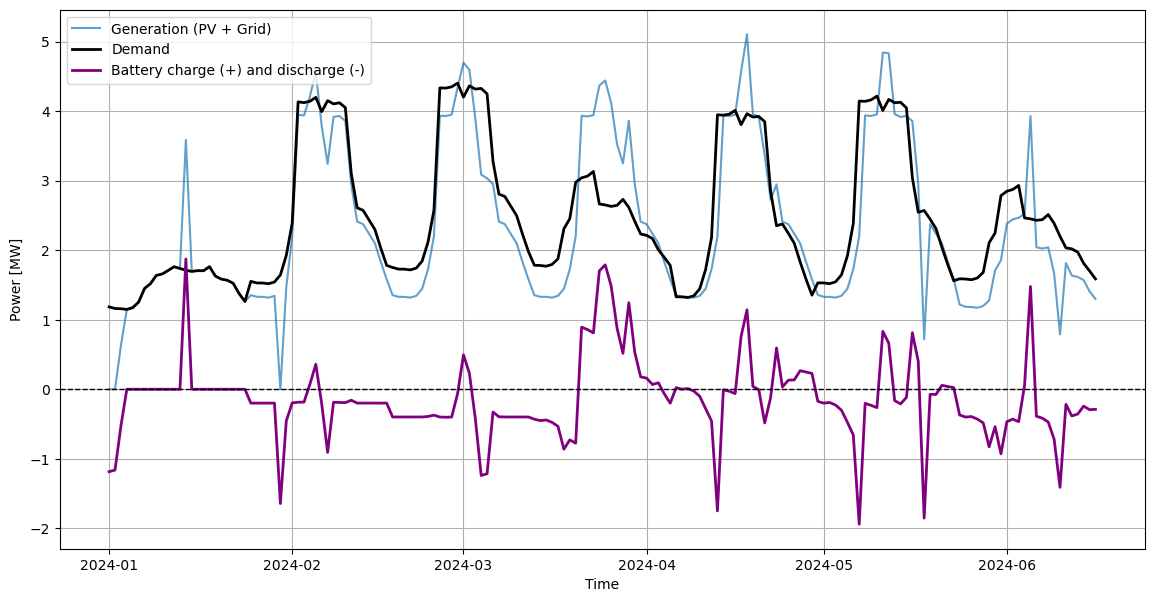

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'g' is already defined and contains the solution dataframe
generation_df = g.solution.to_dataframe().unstack(level=0)
generation_df.columns = generation_df.columns.droplevel(0)

# Ensure the DataFrame has 8760 rows (hours in a year)
if generation_df.shape[0] != 8760:
    raise ValueError("The DataFrame does not have 8760 rows. Check the input data.")

# Create a time index for the x-axis
time_index = pd.date_range(start='2024-01-01', periods=8760)

# Slice the data for the first week (168 hours)
first_week_time_index = time_index[:168]
first_week_generation_df = generation_df.iloc[:168]
first_week_demand = DEMAND.to_series().sort_index().values[:168]

# Sum the generation production across all types
total_generation = first_week_generation_df.sum(axis=1)

# Calculate the difference between total generation and demand
difference = total_generation - first_week_demand

# Plot the total generation, demand, and difference for the first week
plt.figure(figsize=(14, 7))

# Plot the total generation
plt.plot(first_week_time_index, total_generation, label='Generation (PV + Grid)', alpha=0.7)

# Plot the demand
plt.plot(first_week_time_index, first_week_demand, color='black', label='Demand', linewidth=2)

# Plot the difference
plt.plot(first_week_time_index, difference, label='Battery charge (+) and discharge (-)', color='purple', linewidth=2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0 for reference

plt.xlabel("Time")
plt.ylabel("Power [MW]")
#plt.title("Total Production, Demand, and Difference Over the First Week")
plt.legend()
plt.grid()
plt.show()


<Axes: xlabel='Technologies'>

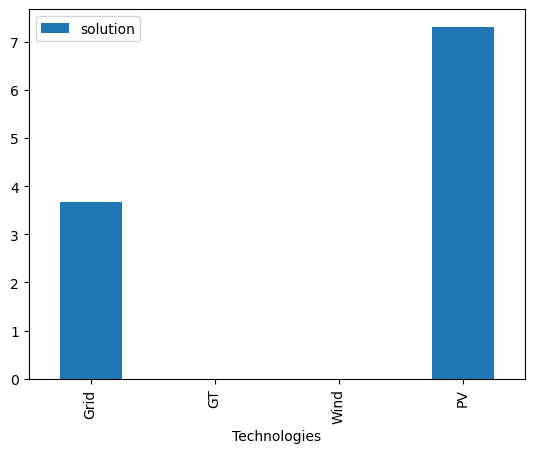

In [13]:
cap_tech.solution.to_dataframe().plot(kind='bar')

In [14]:
cap_tech.solution

<xarray.DataArray 'solution' (Technologies: 4)> Size: 32B
array([3.66336148, 0.        , 0.        , 7.31445925])
Coordinates:
  * Technologies  (Technologies) object 32B 'Grid' 'GT' 'Wind' 'PV'

In [15]:
cap_sto.solution

<xarray.DataArray 'solution' ()> Size: 8B
array(2.2253278)